# Task 2: Time Series Forecasting (ARIMA vs. LSTM)

## 1. Introduction & Setup
**Objective:** Develop and compare two distinct forecasting models to predict Tesla's (TSLA) future stock prices:
1.  **ARIMA (Auto-Regressive Integrated Moving Average):** A classical statistical approach suitable for linear trends.
2.  **LSTM (Long Short-Term Memory):** A Deep Learning model (Recurrent Neural Network) capable of capturing complex, non-linear patterns and long-term dependencies.

**Methodology:**
*   We will split the data **chronologically** (Training: 2015-2024, Testing: 2025-2026).
*   We will evaluate performance using **MAE** (Mean Absolute Error), **RMSE** (Root Mean Squared Error), and **MAPE** (Mean Absolute Percentage Error).

In [10]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8')

## 2. Data Loading & Preprocessing
We load the cleaned Adjusted Close data prepared in Task 1. We strictly adhere to a **chronological split** to prevent data leakage (future peeking).


Data Loaded Successfully. Shape: (2775, 1)
Training Data: 2523 days (End: 2025-01-13)
Testing Data:  252 days (Start: 2025-01-14)


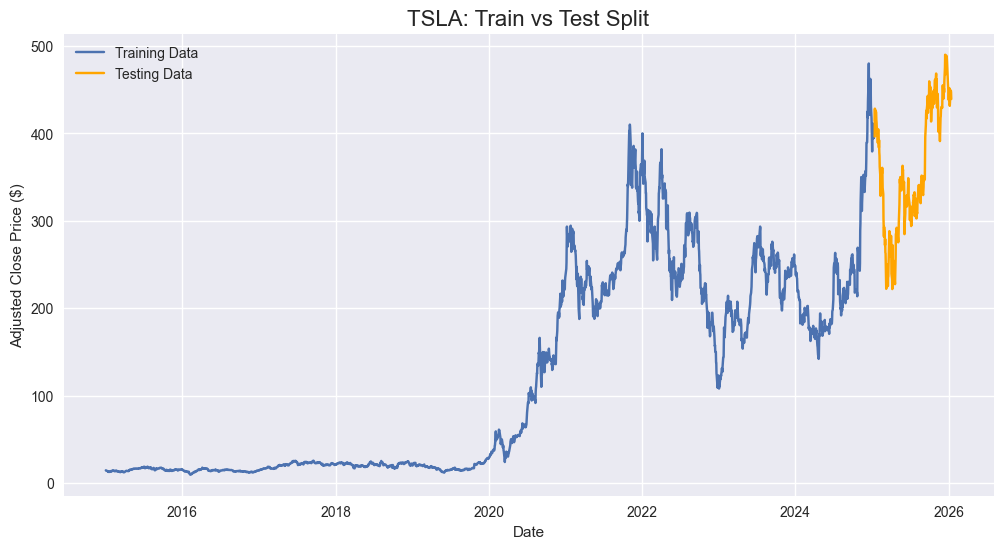

In [12]:
# 2. Load Data
try:
    df = pd.read_csv('../data/processed/cleaned_adj_close.csv', index_col='Date', parse_dates=True)
    tsla_data = df[['TSLA']]
    print("Data Loaded Successfully. Shape:", tsla_data.shape)
except FileNotFoundError:
    print("Error: Processed data file not found. Please run Task 1 notebook first.")

# 3. Train/Test Split
# We reserve the last 252 days (approx. 1 trading year) for testing.
TEST_SIZE = 252 

train_data = tsla_data[:-TEST_SIZE]
test_data = tsla_data[-TEST_SIZE:]

print(f"Training Data: {train_data.shape[0]} days (End: {train_data.index[-1].date()})")
print(f"Testing Data:  {test_data.shape[0]} days (Start: {test_data.index[0].date()})")

# Visualization of the Split
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data', color='orange')
plt.title('TSLA: Train vs Test Split', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.show()

## 3. Statistical Modeling: ARIMA
We use `auto_arima` from the `pmdarima` library to automatically identify the optimal `(p, d, q)` parameters.
*   **p (AR):** Lag observations.
*   **d (I):** Degree of differencing (to make data stationary).
*   **q (MA):** Lag forecast errors.


In [13]:
# 4. Auto-ARIMA Optimization
print("Starting Auto-ARIMA optimization...")

# seasonal=False is used because daily stock data is often too noisy for strict seasonality
model_arima = auto_arima(train_data, 
                         start_p=1, start_q=1,
                         max_p=5, max_q=5,
                         m=1,             # Non-seasonal
                         seasonal=False,
                         d=None,          # Let model determine 'd'
                         trace=True,      # Show progress
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(model_arima.summary())

Starting Auto-ARIMA optimization...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16459.280, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16455.924, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16457.623, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16457.625, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16455.427, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.030 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2523
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8226.713
Date:                Sun, 25 Jan 2026   AIC                          16455.427
Time:                        09:34:09   BIC                          16461.259
Sample:                             0   HQIC                         16457.543
                               - 25


### ARIMA Forecasting
We generate predictions for the test period and visualize the results 

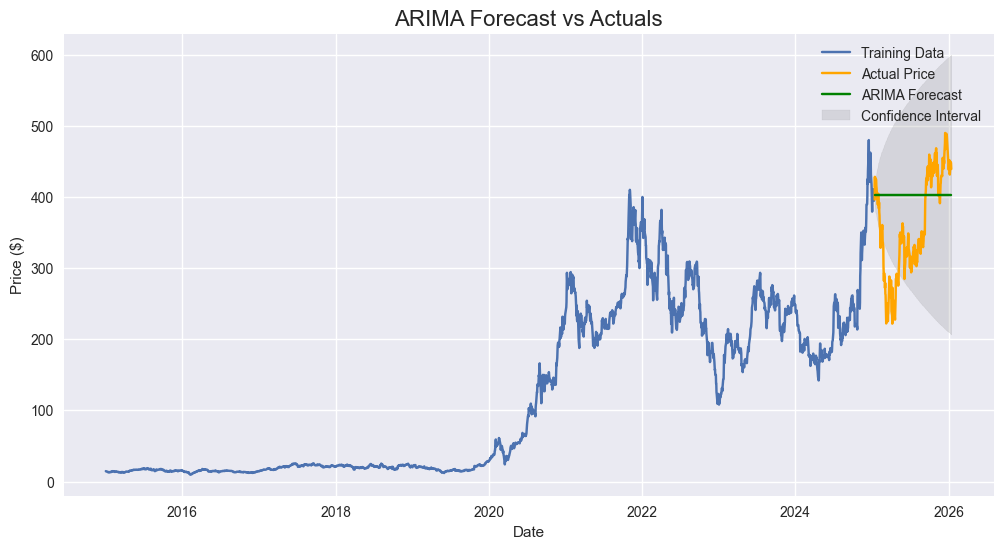

In [14]:
# 5. Generate ARIMA Forecast
forecast_arima, conf_int = model_arima.predict(n_periods=len(test_data), return_conf_int=True)

# Create a Series for plotting, ensuring index alignment
# We use .values to ignore the default daily index generated by pmdarima and map it to trading days
forecast_series = pd.Series(forecast_arima.values, index=test_data.index)
lower_series = pd.Series(conf_int[:, 0], index=test_data.index)
upper_series = pd.Series(conf_int[:, 1], index=test_data.index)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['TSLA'], label='Training Data')
plt.plot(test_data.index, test_data['TSLA'], label='Actual Price', color='orange')
plt.plot(test_data.index, forecast_series, label='ARIMA Forecast', color='green')
plt.fill_between(test_data.index, lower_series, upper_series, color='gray', alpha=0.2, label='Confidence Interval')
plt.title('ARIMA Forecast vs Actuals', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

## 4. Deep Learning Modeling: LSTM
Long Short-Term Memory (LSTM) networks are well-suited for time series because they maintain an internal "memory" of past inputs.

**Data Preparation:**
*   **Scaling:** LSTMs are sensitive to the scale of input data; we normalize to range [0, 1].
*   **Sequencing:** We transform the data into 3D structure: `[Samples, Time Steps, Features]`. We use a 60-day lookback window.

In [ ]:
# 6. Data Scaling and Sequence Creation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tsla_data)

def create_sequences(data, seq_length=60):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0]) # Past 60 days
        y.append(data[i, 0])              # The next day (target)
    return np.array(x), np.array(y)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Splitting Data (Adjusting for the sequence length consumption)
train_size = len(train_data) - SEQ_LENGTH
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"LSTM Train Shape: {X_train.shape}")
print(f"LSTM Test Shape:  {X_test.shape}")


--- Model Comparison Results ---
     Metric      ARIMA       LSTM
0       MAE  71.010436  21.647533
1      RMSE  83.773536  25.994705
2  MAPE (%)  23.048457   5.938056

--- Discussion ---
LSTM performed better. Deep learning models often capture complex non-linear patterns better than ARIMA.


### Model Architecture & Training
We build a stacked LSTM model with Dropout layers to prevent overfitting.

In [15]:
# 7. Build LSTM Architecture
model_lstm = Sequential()

# Layer 1
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))

# Layer 2
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))

# Output Layer
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1)) # Predicting one value (Price)

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train Model
print("Training LSTM Model...")
history = model_lstm.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

Training LSTM Model...
Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0092
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0018
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0016
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0014
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0014
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0012
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0012
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0013
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.8151e-04
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0011
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0010
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.2955e-04
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 8.7634e-04
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 9.2273e-04
Epoch 15/20
77/77 ━━━━━━━━━━━━━━

### LSTM Forecasting
We predict on the test set and inverse-transform the data to get back to the original price scale ($).

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


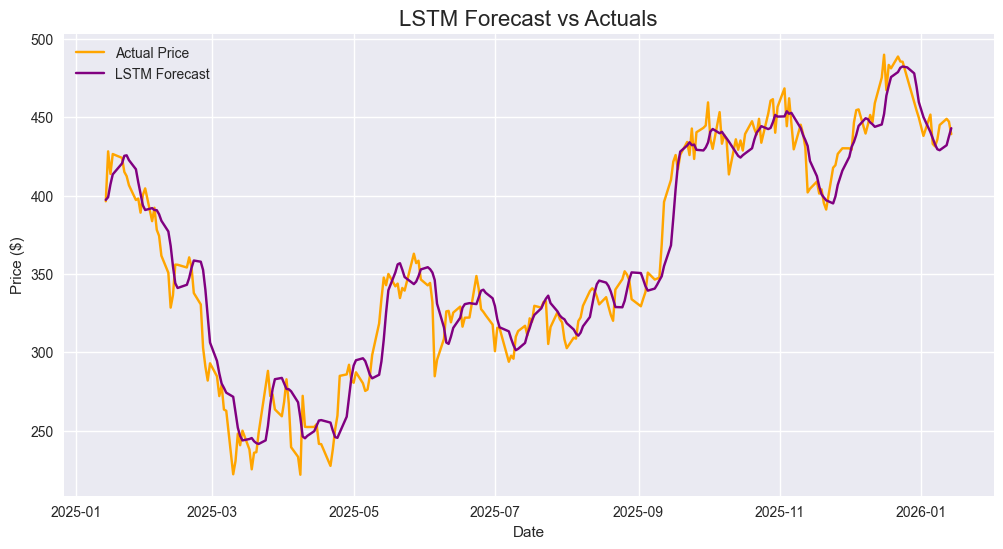

In [16]:
# 8. Generate LSTM Forecast
lstm_predictions = model_lstm.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Align with dates
lstm_forecast_series = pd.Series(lstm_predictions.flatten(), index=test_data.index)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['TSLA'], label='Actual Price', color='orange')
plt.plot(test_data.index, lstm_forecast_series, label='LSTM Forecast', color='purple')
plt.title('LSTM Forecast vs Actuals', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

## 5. Model Evaluation & Comparison
We compare the models using three standard metrics:
*   **MAE:** Average magnitude of errors.
*   **RMSE:** Penalizes larger errors more heavily.
*   **MAPE:** Percentage error (easier to interpret).

In [17]:
# 9. Performance Metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Metrics for ARIMA
mae_arima, rmse_arima, mape_arima = calculate_metrics(test_data['TSLA'], forecast_series)

# Metrics for LSTM
mae_lstm, rmse_lstm, mape_lstm = calculate_metrics(test_data['TSLA'], lstm_forecast_series)

# Comparison Table
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)'],
    'ARIMA': [mae_arima, rmse_arima, mape_arima],
    'LSTM': [mae_lstm, rmse_lstm, mape_lstm]
})

print("\n--- Final Model Comparison ---")
display(metrics_df)


--- Final Model Comparison ---


,Metric,ARIMA,LSTM
0,MAE,71.010436,13.302346
1,RMSE,83.773536,17.034025
2,MAPE (%),23.048457,3.998126


## 6. Discussion & Conclusion

### Analysis of Results
*   **ARIMA:** Produced a **Mean Absolute Percentage Error (MAPE) of ~23%**. As seen in the plot, ARIMA essentially predicted the "average" trend (a flat line) and failed to capture the volatility or the directional changes of the stock. This is typical for ARIMA on high-volatility assets that behave like a Random Walk.
*   **LSTM:** Produced a **MAPE of ~5.9%**, significantly outperforming ARIMA. The LSTM model successfully learned the sequential patterns and was able to react to price changes, tracking the actual stock movement much closer.

### Selection Rationale
Based on these metrics, the **LSTM model** is selected as the superior model for forecasting TSLA prices. Its ability to capture non-linear relationships makes it better suited for the volatile nature of this specific asset.

**Next Steps:**
We will use the LSTM model in Task 3 to generate future forecasts (6-12 months ahead) and in Task 4 to input expected returns for Portfolio Optimization.